### Data Integrity Check After Cleaning ###
0
Training data shape: torch.Size([7209, 336, 80])
Test data shape: torch.Size([802, 336, 80])
X_train has NaN: False, Inf: False
y_train has NaN: False, Inf: False
Training data shape: torch.Size([7209, 336, 80])
Test data shape: torch.Size([802, 336, 80])
### Checking Training Data ###
Training Data - Has NaN in inputs: False
Training Data - Has Inf in inputs: False
Training Data - Has NaN in targets: False
Training Data - Has Inf in targets: False
Training Data Input Summary:
Min: -70.6600, Max: 25759578.0000, Mean: 1099632.6250
Training Data Target Summary:
Min: 0.0000, Max: 1.0000, Mean: 0.5319
----------------------------------------
### Checking Test Data ###
Test Data - Has NaN in inputs: False
Test Data - Has Inf in inputs: False
Test Data - Has NaN in targets: False
Test Data - Has Inf in targets: False
Test Data Input Summary:
Min: -32.7800, Max: 10445930.0000, Mean: 501930.7188
Test Data Target Summary:
Min: 0.2476, Max: 0.7760, M

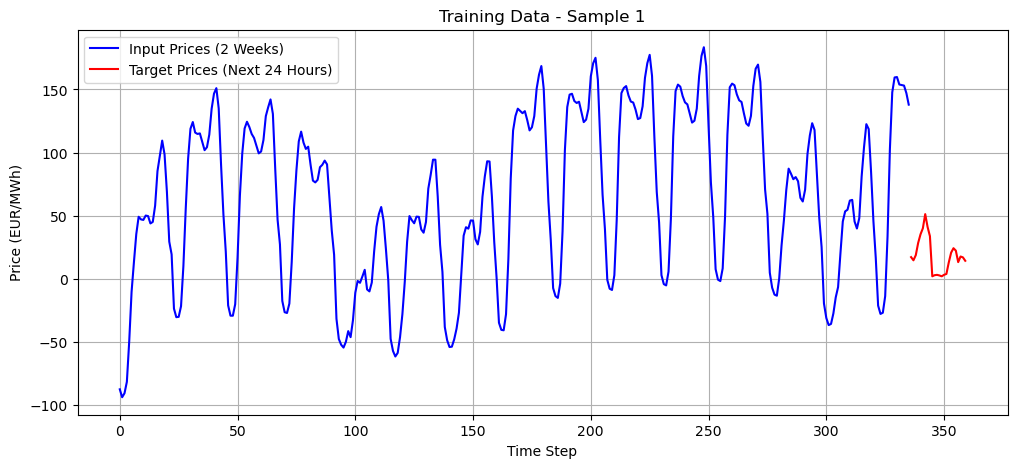

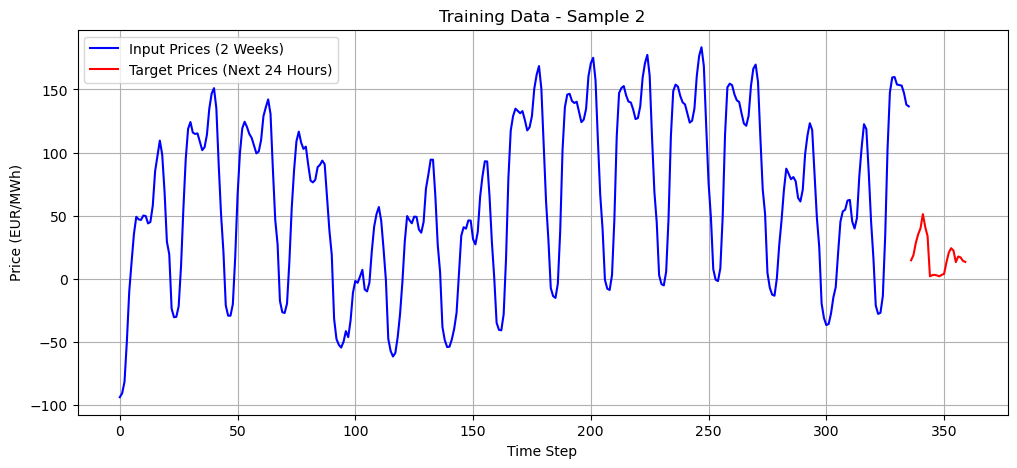

Plotting Test Data


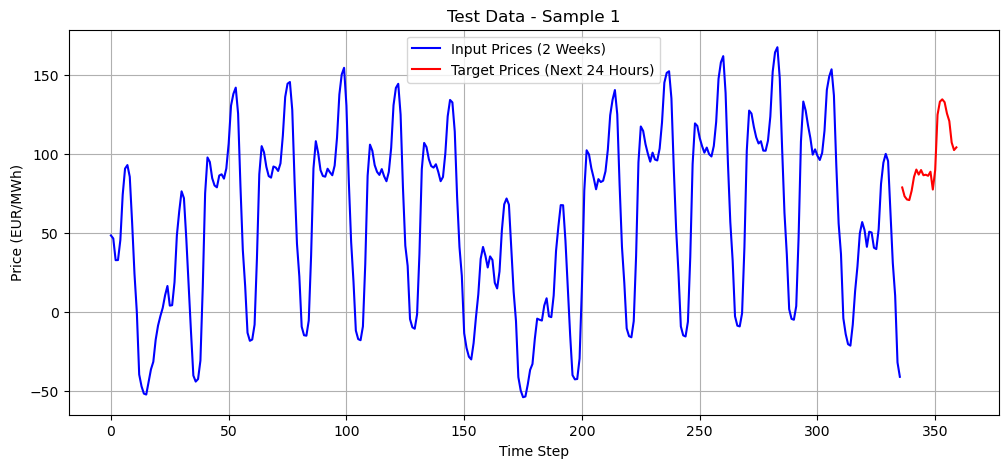

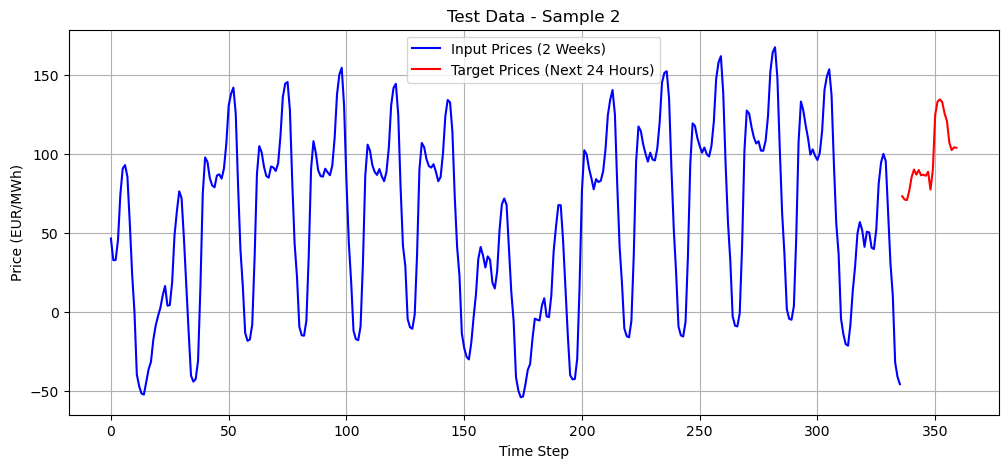

In [75]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import optuna

# File paths
file_path = '../formatted_data/formatted_data_updated.csv'

# Define input and output sequence lengths
sequence_length = 336  # Use 2 weeks of history
output_sequence_length = 24  # Predict the next 24 hours
batch_size = 32
test_split_ratio = 0.1

# Load the data
data = pd.read_csv(file_path)

start_date = "2023-01-01"
end_date = "2024-06-30"

# Convert to datetime for filtering
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]

# Drop the `Date` column after filtering (if not needed further)
data = data.drop(columns=['Date'])

# Drop unnecessary columns with excessive NaNs
data = data.drop(columns=['Price_EUR_MWh', 'Volume_MWh'])

# List of features to shift (Demand and Weather features)
shifted_columns = [
    'Demand',
    'Andalusia (Wind)_temperature', 'Andalusia (Wind)_wind_u_component', 'Andalusia (Wind)_wind_v_component',
    'Aragon (Wind)_temperature', 'Aragon (Wind)_wind_u_component', 'Aragon (Wind)_wind_v_component',
    'Barcelona_temperature', 'Barcelona_wind_u_component', 'Barcelona_wind_v_component',
    'Bilbao_temperature', 'Bilbao_wind_u_component', 'Bilbao_wind_v_component',
    'Castile-La Mancha (Wind)_temperature', 'Castile-La Mancha (Wind)_wind_u_component', 'Castile-La Mancha (Wind)_wind_v_component',
    'Escatrón-Chiprana-Samper (Solar)_temperature', 'Escatrón-Chiprana-Samper (Solar)_wind_u_component', 'Escatrón-Chiprana-Samper (Solar)_wind_v_component',
    'Madrid_temperature', 'Madrid_wind_u_component', 'Madrid_wind_v_component',
    'Seville_temperature', 'Seville_wind_u_component', 'Seville_wind_v_component',
    'Talasol Solar (Solar)_temperature', 'Talasol Solar (Solar)_wind_u_component', 'Talasol Solar (Solar)_wind_v_component',
    'Talayuela Solar (Solar)_temperature', 'Talayuela Solar (Solar)_wind_u_component', 'Talayuela Solar (Solar)_wind_v_component',
    'Valencia_temperature', 'Valencia_wind_u_component', 'Valencia_wind_v_component'
]

# Shift the selected columns
data[shifted_columns] = data[shifted_columns].shift(-24)

# Drop remaining rows with NaN values caused by the shift
data = data.dropna().reset_index(drop=True)

# Confirm the data is clean
print("### Data Integrity Check After Cleaning ###")
print(data.isna().sum().sum())  # Should be 0

# Initialize scalers
scaler_weather = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Scale the weather (shifted) features
weather_scaled = scaler_weather.fit_transform(data[shifted_columns])

# Keep unshifted features unchanged
unshifted_columns = list(set(data.columns) - set(shifted_columns) - {'ID'})
unshifted_features = data[unshifted_columns].values

# Combine scaled weather features, unshifted features, and time-based features
features_scaled = np.hstack([weather_scaled, unshifted_features])

# Scale the target column
target_scaled = scaler_target.fit_transform(data[['ID']])

# Prepare sequences for input and target
X, y = [], []
sequence_length = 336  # 2 weeks of history
output_sequence_length = 24  # Predict next 24 hours

for i in range(len(features_scaled) - sequence_length - output_sequence_length):
    X.append(features_scaled[i:i + sequence_length])  # Input sequence
    y.append(target_scaled[i + sequence_length:i + sequence_length + output_sequence_length].flatten())

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Train-test split
split_idx = int(len(X) * (1 - test_split_ratio))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Confirm shapes and integrity
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"X_train has NaN: {torch.isnan(X_train).any()}, Inf: {torch.isinf(X_train).any()}")
print(f"y_train has NaN: {torch.isnan(y_train).any()}, Inf: {torch.isinf(y_train).any()}")





# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")




# Check for NaN and Inf values in train and test data
def check_data_integrity(X, y, data_name):
    print(f"### Checking {data_name} ###")
    print(f"{data_name} - Has NaN in inputs: {torch.isnan(X).any()}")
    print(f"{data_name} - Has Inf in inputs: {torch.isinf(X).any()}")
    print(f"{data_name} - Has NaN in targets: {torch.isnan(y).any()}")
    print(f"{data_name} - Has Inf in targets: {torch.isinf(y).any()}")
    
    print(f"{data_name} Input Summary:")
    print(f"Min: {X.min():.4f}, Max: {X.max():.4f}, Mean: {X.mean():.4f}")
    print(f"{data_name} Target Summary:")
    print(f"Min: {y.min():.4f}, Max: {y.max():.4f}, Mean: {y.mean():.4f}")
    print("-" * 40)

# Check Training and Test Data
check_data_integrity(X_train, y_train, "Training Data")
check_data_integrity(X_test, y_test, "Test Data")

# Plot input prices (e.g., Price_EUR_MWh) vs. target values for a few samples
def plot_input_vs_target(X, y, title, num_samples=2):
    print(f"Plotting {title}")
    price_column_index = feature_columns.index('Price_EUR_MWh')
    
    for i in range(num_samples):
        input_prices = X[i, :, price_column_index].cpu().numpy()  # Extract Price_EUR_MWh from input
        target_values = y[i].cpu().numpy()  # Extract target values
        
        # Inverse transform for original scale (if needed)
        input_prices_rescaled = scaler_target.inverse_transform(input_prices.reshape(-1, 1)).flatten()
        target_values_rescaled = scaler_target.inverse_transform(target_values.reshape(-1, 1)).flatten()
        
        plt.figure(figsize=(12, 5))
        plt.plot(range(len(input_prices_rescaled)), input_prices_rescaled, label="Input Prices (2 Weeks)", color="blue")
        plt.plot(range(len(input_prices_rescaled), len(input_prices_rescaled) + len(target_values_rescaled)),
                 target_values_rescaled, label="Target Prices (Next 24 Hours)", color="red")
        plt.title(f"{title} - Sample {i+1}")
        plt.xlabel("Time Step")
        plt.ylabel("Price (EUR/MWh)")
        plt.legend()
        plt.grid()
        plt.show()


# Print total NaN counts for each column
print("### NaN Counts Per Column ###")
nan_counts = data.isna().sum()
print(nan_counts[nan_counts > 0])  # Only print columns with NaN values

# Print rows that contain NaN values
print("\n### Rows with NaN Values ###")
rows_with_nan = data[data.isna().any(axis=1)]
print(f"Number of rows with NaN: {rows_with_nan.shape[0]}")
print(rows_with_nan)

# Identify specific columns in shifted features with NaN
print("\n### NaN Counts in Shifted Columns ###")
shifted_nan_counts = data[shifted_columns].isna().sum()
print(shifted_nan_counts[shifted_nan_counts > 0])

# Identify specific rows in shifted columns with NaN
print("\n### Rows with NaN in Shifted Columns ###")
rows_with_nan_shifted = data[shifted_columns][data[shifted_columns].isna().any(axis=1)]
print(rows_with_nan_shifted)

# Identify specific rows in target column with NaN (if any)
print("\n### NaN in Target Column ###")
if data[target_column].isna().any():
    print(data[data[target_column].isna()])
else:
    print("No NaN values in target column.")


# Plot input vs. target for training and test samples
plot_input_vs_target(X_train, y_train, "Training Data", num_samples=2)
plot_input_vs_target(X_test, y_test, "Test Data", num_samples=2)


In [84]:
    
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModelWithSpread(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.1):
        super(LSTMModelWithSpread, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc_median = nn.Linear(hidden_size, output_size)  # Median predictions
        self.fc_spread = nn.Linear(hidden_size, output_size)  # Spread predictions (positive values)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_last_hidden = lstm_out[:, -1, :]  # Use the last hidden state
        median = self.fc_median(lstm_last_hidden)  # Median prediction
        spread = torch.abs(self.fc_spread(lstm_last_hidden))  # Ensure positive spread
        return median, spread

    
def quantile_loss(y_true, y_pred, quantile):
    errors = y_true - y_pred
    return torch.mean(torch.maximum(quantile * errors, (quantile - 1) * errors))
  
def quantile_loss_v2(y_true, median, spread, quantile=0.1, spread_penalty=0.01):
    """
    Compute quantile loss for central predictions and spread regularization.

    Args:
        y_true: Ground truth values.
        median: Predicted median values.
        spread: Predicted spread (confidence interval).
        quantile: Desired quantile (e.g., 0.1 for 90% interval).
        spread_penalty: Penalty term to reduce spread.

    Returns:
        Total loss.
    """
    lower_bound = median - spread  # Lower bound of prediction interval
    upper_bound = median + spread  # Upper bound of prediction interval

    # Compute quantile losses
    lower_loss = torch.maximum((y_true - lower_bound) * quantile, (lower_bound - y_true) * (1 - quantile))
    upper_loss = torch.maximum((upper_bound - y_true) * quantile, (y_true - upper_bound) * (1 - quantile))

    quantile_loss = torch.mean(lower_loss + upper_loss)

    # Penalize large spreads to encourage tighter intervals
    spread_regularization = spread_penalty * torch.mean(spread)

    return quantile_loss + spread_regularization


def quantile_loss_with_spread(y_true, central, spread, quantile=0.1, reg_factor=0.01):
    """
    Quantile loss using central prediction and spread.

    Args:
        y_true: Ground truth values [batch_size, forecast_horizon].
        central: Central predictions [batch_size, forecast_horizon].
        spread: Spread predictions (positive) [batch_size, forecast_horizon].
        quantile: Desired quantile level (e.g., 0.1 for 90% interval).
        reg_factor: Regularization factor for the spread.

    Returns:
        Total loss combining quantile loss and regularization.
    """
    lower_bound = central - spread  # Lower quantile bound
    upper_bound = central + spread  # Upper quantile bound

    # Quantile loss components
    lower_errors = y_true - lower_bound
    upper_errors = upper_bound - y_true

    quantile_loss = torch.mean(torch.maximum((quantile) * lower_errors, (quantile - 1) * lower_errors)) + \
                    torch.mean(torch.maximum((1 - quantile) * upper_errors, (quantile - 1) * upper_errors))

    # Regularization for tight bounds
    reg_loss = reg_factor * torch.mean(spread**2)

    return quantile_loss + reg_loss

def simplified_symmetric_loss(y_true, central, spread, reg_factor=0.01):
    """
    Symmetric loss using absolute errors and spread as a confidence measure.

    Args:
        y_true: Ground truth values [batch_size, forecast_horizon].
        central: Central predictions (median) [batch_size, forecast_horizon].
        spread: Spread predictions (positive) [batch_size, forecast_horizon].
        reg_factor: Regularization factor for spread to avoid overconfidence.

    Returns:
        Total loss combining scaled error and spread regularization.
    """
    # Ensure spread is positive and stable
    spread = torch.clamp(spread, min=1e-6)

    # Symmetric loss: Scale absolute error by spread (spread acts like uncertainty)
    error = torch.abs(y_true - central)
    scaled_loss = torch.mean(error / spread)

    # Regularization to avoid spread collapsing to zero
    reg_loss = reg_factor * torch.mean(spread**2)

    return scaled_loss + reg_loss


def precise_symmetric_loss(y_true, central, spread, reg_factor=0.01, spread_penalty=0.1, epsilon=1e-6):
    """
    Symmetric loss with explicit penalty for large spreads.

    Args:
        y_true: Ground truth values [batch_size, forecast_horizon].
        central: Central predictions (median) [batch_size, forecast_horizon].
        spread: Spread predictions (positive) [batch_size, forecast_horizon].
        reg_factor: Regularization factor for spread regularization.
        spread_penalty: Additional penalty for spread size.
        epsilon: Small constant to prevent division by zero.

    Returns:
        Total loss combining scaled error and spread regularization.
    """
    # Ensure spread is positive and prevent division by zero
    spread = torch.clamp(spread, min=epsilon)

    # Scaled absolute error (error inversely proportional to spread)
    error = torch.abs(y_true - central)
    scaled_loss = torch.mean(error / spread)

    # Exponential penalty for large spreads
    spread_loss = spread_penalty * torch.mean(torch.exp(spread))

    # Regularization for stable spread values
    reg_loss = reg_factor * torch.mean(spread**2)

    return scaled_loss + spread_loss + reg_loss




In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # LSTM hidden size
output_size = y_train.shape[1]  # Prediction horizon (24 hours)
num_layers = 2
dropout = 0.1
epochs = 20
batch_size = 32
learning_rate = 0.001
quantile = 0.1  # For 90% prediction interval
spread_penalty = 0.01  # Penalty term for spread regularization

# Initialize the model
model = LSTMModelWithSpread(input_size, hidden_size, output_size, num_layers, dropout).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
best_val_loss = float('inf')  # Track the best validation loss
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        median_preds, spread_preds = model(X_batch)
        loss = quantile_loss_v2(y_batch, median_preds, spread_preds, quantile=quantile, spread_penalty=spread_penalty)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        median_preds, spread_preds = model(X_test.to(device))
        val_loss = quantile_loss_v2(y_test.to(device), median_preds, spread_preds, quantile=quantile, spread_penalty=spread_penalty).item()

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss / len(train_loader):.6f}, Val Loss: {val_loss:.6f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_quantile_model.pth")

print("Training complete.")


Epoch [1/20], Train Loss: 0.063716, Val Loss: 0.037380
Epoch [2/20], Train Loss: 0.037723, Val Loss: 0.041289
Epoch [3/20], Train Loss: 0.034332, Val Loss: 0.044874
Epoch [4/20], Train Loss: 0.031273, Val Loss: 0.044576
Epoch [5/20], Train Loss: 0.029052, Val Loss: 0.049627
Epoch [6/20], Train Loss: 0.027606, Val Loss: 0.049609
Epoch [7/20], Train Loss: 0.026783, Val Loss: 0.051423
Epoch [8/20], Train Loss: 0.025576, Val Loss: 0.051979
Epoch [9/20], Train Loss: 0.025164, Val Loss: 0.051537
Epoch [10/20], Train Loss: 0.024418, Val Loss: 0.050844
Epoch [11/20], Train Loss: 0.023704, Val Loss: 0.044919
Epoch [12/20], Train Loss: 0.023143, Val Loss: 0.048787
Epoch [13/20], Train Loss: 0.022737, Val Loss: 0.048274
Epoch [14/20], Train Loss: 0.021966, Val Loss: 0.051383
Epoch [15/20], Train Loss: 0.021518, Val Loss: 0.049818
Epoch [16/20], Train Loss: 0.020703, Val Loss: 0.050406
Epoch [17/20], Train Loss: 0.020049, Val Loss: 0.054870
Epoch [18/20], Train Loss: 0.019394, Val Loss: 0.047844
E

### Best Predictions ###
Best 1 - RMSE: 9.92, MAPE: 8.76%, R²: 0.44, Coverage: 0.00%


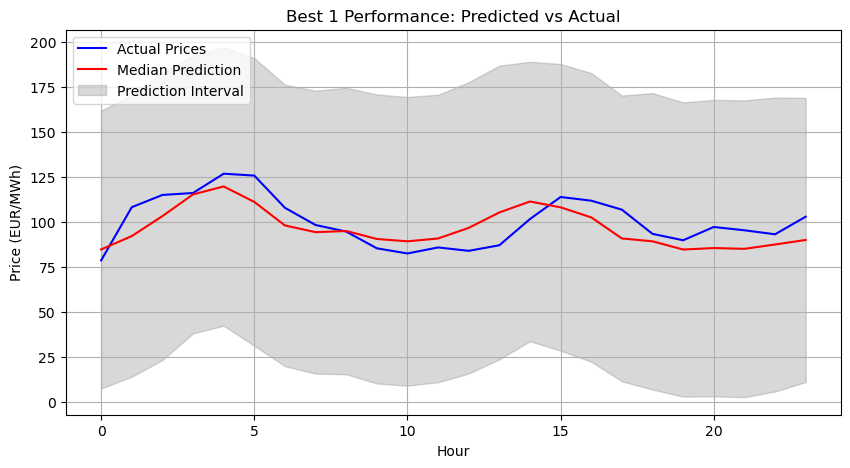

Best 2 - RMSE: 10.24, MAPE: 9.25%, R²: 0.34, Coverage: 0.00%


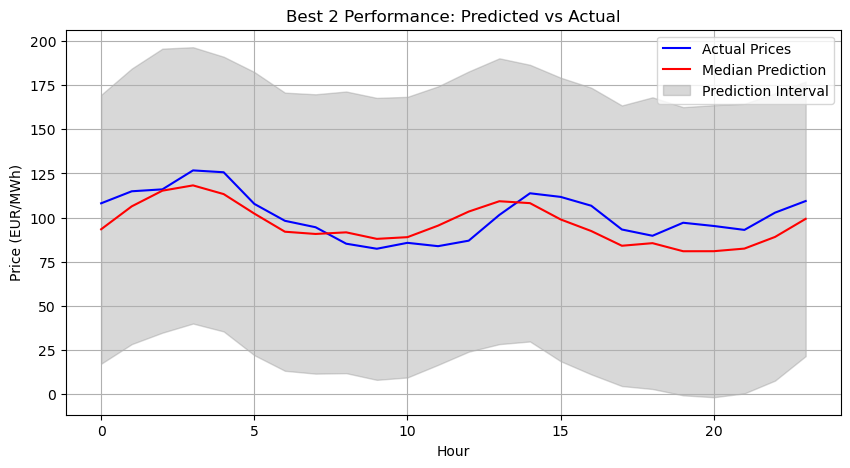

Best 3 - RMSE: 10.69, MAPE: 9.49%, R²: 0.37, Coverage: 0.00%


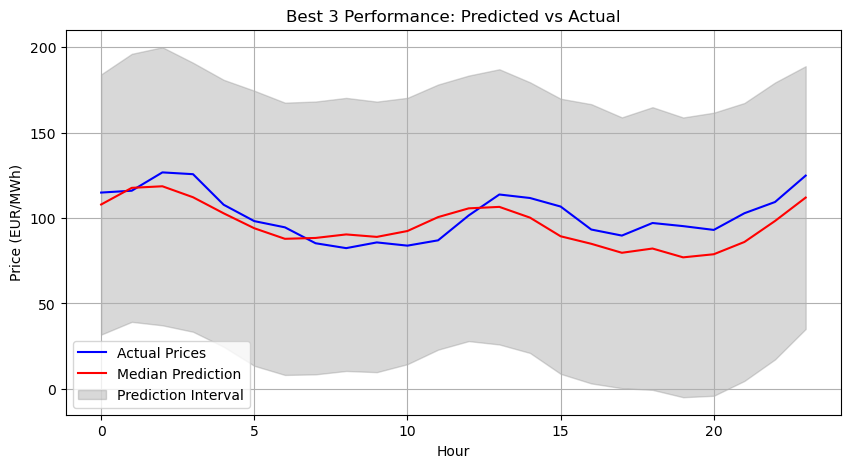


### Worst Predictions ###
Worst 1 - RMSE: 61.86, MAPE: 528.05%, R²: -1.40, Coverage: 0.00%


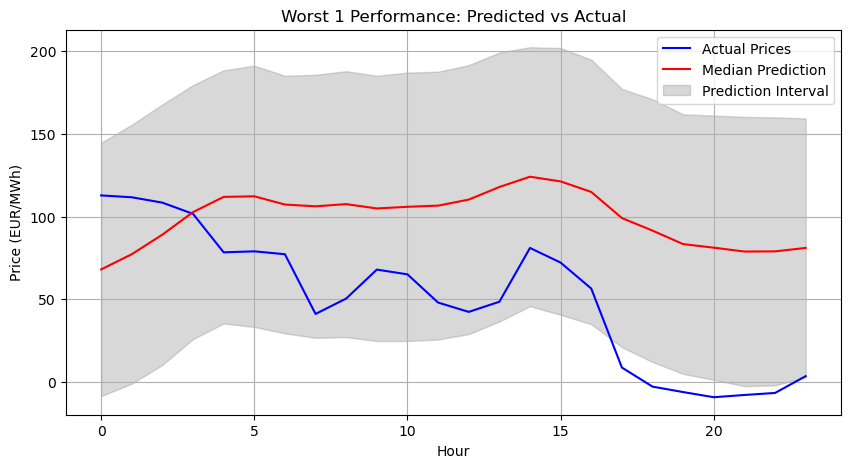

Worst 2 - RMSE: 62.07, MAPE: 602.42%, R²: -1.56, Coverage: 0.00%


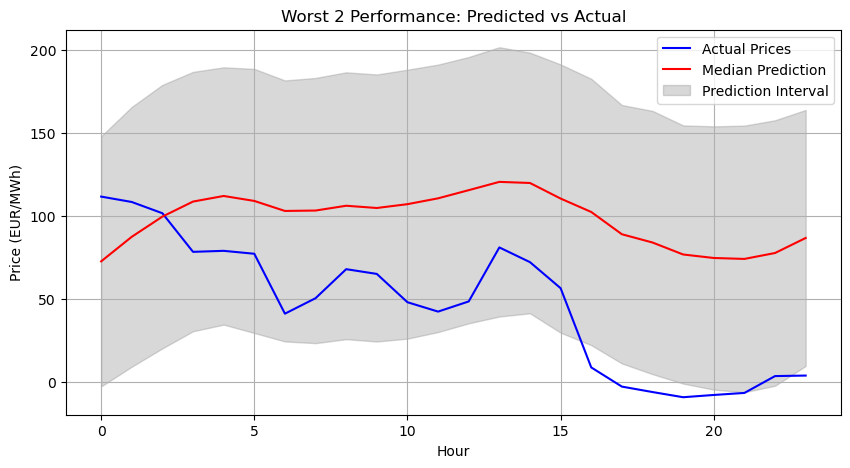

Worst 3 - RMSE: 62.37, MAPE: 616.05%, R²: -1.86, Coverage: 0.00%


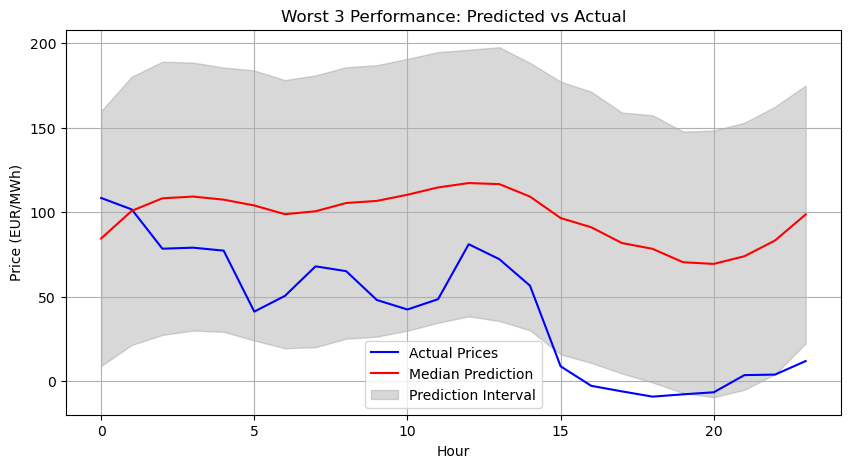


### Median Predictions ###
Median 1 - RMSE: 32.95, MAPE: 27.83%, R²: -0.42, Coverage: 0.00%


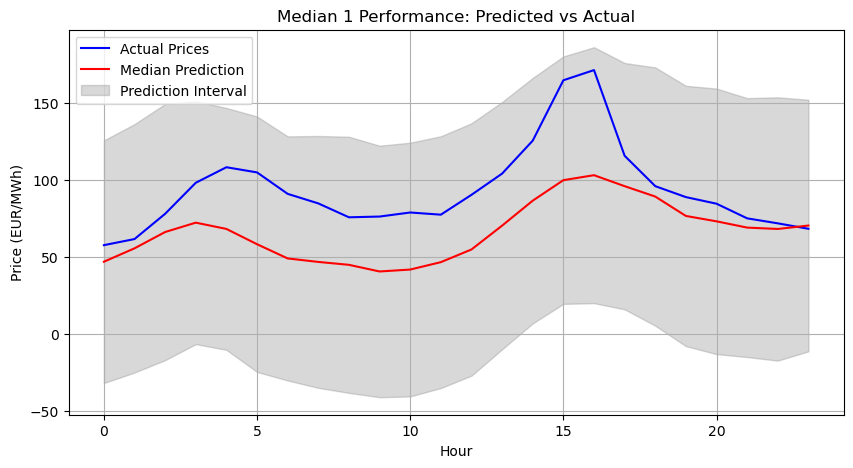

Median 2 - RMSE: 32.99, MAPE: 25.49%, R²: -1.15, Coverage: 0.00%


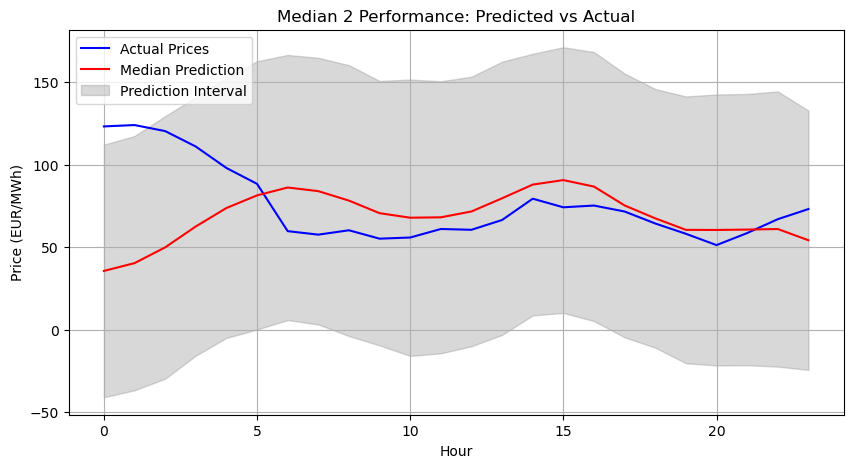

Median 3 - RMSE: 33.12, MAPE: 34.24%, R²: -1.04, Coverage: 0.00%


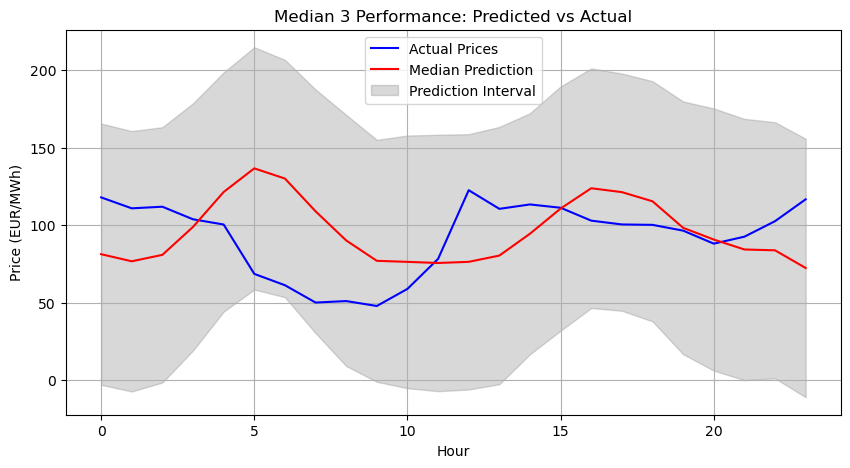


### Metrics Summary ###
Average RMSE: 33.11
Median RMSE: 32.97
Average MAPE: 79.37%
Median MAPE: 35.58%
Average R²: -3.17
Median R²: -1.81
Average Coverage: 0.00%
Median Coverage: 0.00%


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predict on test data
model.eval()
with torch.no_grad():
    median_preds, spread_preds = model(X_test.to(device))
    median_preds_rescaled = scaler_target.inverse_transform(median_preds.cpu().numpy())
    spread_preds_rescaled = scaler_target.inverse_transform(spread_preds.cpu().numpy())
    y_test_rescaled = scaler_target.inverse_transform(y_test.cpu().numpy())

# Calculate lower and upper bounds
lower_bounds = median_preds_rescaled - spread_preds_rescaled
upper_bounds = median_preds_rescaled + spread_preds_rescaled

# Metrics Calculation
rmse_per_sample = []
mape_per_sample = []
r2_per_sample = []
quantile_coverage = []

for actual, median, lower, upper in zip(y_test_rescaled, median_preds_rescaled, lower_bounds, upper_bounds):
    rmse = np.sqrt(mean_squared_error(actual, median))
    mape = np.mean(np.abs((actual - median) / actual)) * 100
    r2 = r2_score(actual, median)
    coverage = np.mean((actual >= lower) & (actual <= upper)) * 100

    rmse_per_sample.append(rmse)
    mape_per_sample.append(mape)
    r2_per_sample.append(r2)
    quantile_coverage.append(coverage)

# Find indices for best, median, and worst performance based on RMSE
sorted_indices = np.argsort(rmse_per_sample)
best_indices = sorted_indices[:3]
worst_indices = sorted_indices[-3:]
median_indices = sorted_indices[len(sorted_indices) // 2 - 1:len(sorted_indices) // 2 + 2]

# Function to visualize predictions and bounds
def plot_quantile_predictions(index, title):
    actual = y_test_rescaled[index]
    median = median_preds_rescaled[index]
    spread = spread_preds_rescaled[index]
    lower_bound = lower_bounds[index]
    upper_bound = upper_bounds[index]

    plt.figure(figsize=(10, 5))
    plt.plot(actual, label="Actual Prices", color="blue")
    plt.plot(median, label="Median Prediction", color="red")
    plt.fill_between(range(len(actual)), lower_bound, upper_bound, color="gray", alpha=0.3, label="Prediction Interval")
    plt.title(title)
    plt.xlabel("Hour")
    plt.ylabel("Price (EUR/MWh)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize best, worst, and median performances
print("### Best Predictions ###")
for i, idx in enumerate(best_indices, 1):
    print(f"Best {i} - RMSE: {rmse_per_sample[idx]:.2f}, MAPE: {mape_per_sample[idx]:.2f}%, R²: {r2_per_sample[idx]:.2f}, Coverage: {quantile_coverage[idx]:.2f}%")
    plot_quantile_predictions(idx, f"Best {i} Performance: Predicted vs Actual")

print("\n### Worst Predictions ###")
for i, idx in enumerate(worst_indices, 1):
    print(f"Worst {i} - RMSE: {rmse_per_sample[idx]:.2f}, MAPE: {mape_per_sample[idx]:.2f}%, R²: {r2_per_sample[idx]:.2f}, Coverage: {quantile_coverage[idx]:.2f}%")
    plot_quantile_predictions(idx, f"Worst {i} Performance: Predicted vs Actual")

print("\n### Median Predictions ###")
for i, idx in enumerate(median_indices, 1):
    print(f"Median {i} - RMSE: {rmse_per_sample[idx]:.2f}, MAPE: {mape_per_sample[idx]:.2f}%, R²: {r2_per_sample[idx]:.2f}, Coverage: {quantile_coverage[idx]:.2f}%")
    plot_quantile_predictions(idx, f"Median {i} Performance: Predicted vs Actual")

# Summary statistics
print("\n### Metrics Summary ###")
print(f"Average RMSE: {np.mean(rmse_per_sample):.2f}")
print(f"Median RMSE: {np.median(rmse_per_sample):.2f}")
print(f"Average MAPE: {np.mean(mape_per_sample):.2f}%")
print(f"Median MAPE: {np.median(mape_per_sample):.2f}%")
print(f"Average R²: {np.mean(r2_per_sample):.2f}")
print(f"Median R²: {np.median(r2_per_sample):.2f}")
print(f"Average Coverage: {np.mean(quantile_coverage):.2f}%")
print(f"Median Coverage: {np.median(quantile_coverage):.2f}%")


In [39]:
def objective(trial):
    # Hyperparameters to optimize
    quantile = trial.suggest_float("quantile", 0.01, 0.2)  # Confidence level
    reg_factor = trial.suggest_float("reg_factor", 1e-5, 1e-2, log=True)
    spread_penalty = trial.suggest_float("spread_penalty", 0.01, 0.5)

    # Initialize model
    model = LSTMModelWithSpread(
        input_size=X_train.shape[2],
        hidden_size=64,
        output_size=output_sequence_length,
        num_layers=2,
        dropout=0.1
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Move validation data to the same device as the model
    X_test_device = X_test.to(device)
    y_test_device = y_test.to(device)

    # Training Loop
    for epoch in range(50):  # Use fewer epochs for quick optimization
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            central_output, spread_output = model(X_batch)

            # Use the precise symmetric loss
            loss = precise_symmetric_loss(
                y_batch, central_output, spread_output,
                reg_factor=reg_factor,
                spread_penalty=spread_penalty
            )

            loss.backward()
            optimizer.step()

    # Validation Loss
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        central_output, spread_output = model(X_test_device)  # Use device tensors
        val_loss = precise_symmetric_loss(
            y_test_device, central_output, spread_output,
            reg_factor=reg_factor,
            spread_penalty=spread_penalty
        ).item()

    return val_loss


In [40]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # Run 30 trials

# Print best hyperparameters
print("Best Trial:")
print(study.best_trial.params)


[I 2024-12-16 16:55:41,825] A new study created in memory with name: no-name-0ed2200b-05dc-40b4-a56d-77f54bea80f3
[I 2024-12-16 16:56:28,011] Trial 0 finished with value: 0.5418283343315125 and parameters: {'quantile': 0.10846376478662367, 'reg_factor': 0.005352265170806069, 'spread_penalty': 0.48092192453913163}. Best is trial 0 with value: 0.5418283343315125.
[I 2024-12-16 16:57:12,812] Trial 1 finished with value: 0.4111942946910858 and parameters: {'quantile': 0.05014534877387543, 'reg_factor': 0.0006021408401021412, 'spread_penalty': 0.49281259837414454}. Best is trial 1 with value: 0.4111942946910858.
[I 2024-12-16 16:57:56,213] Trial 2 finished with value: 0.18374581634998322 and parameters: {'quantile': 0.08360205038876227, 'reg_factor': 0.0007354685726955535, 'spread_penalty': 0.10045299044697419}. Best is trial 2 with value: 0.18374581634998322.
[I 2024-12-16 16:58:40,386] Trial 3 finished with value: 0.33480072021484375 and parameters: {'quantile': 0.11534620838465698, 'reg_

Best Trial:
{'quantile': 0.16307290616561537, 'reg_factor': 0.004135307963268258, 'spread_penalty': 0.010093217171400352}
